<h1 align="center">UW CNC Fall Hackathon </h1>  
<h3 align="center"> Dec 4, 2024 </h3>   
<h3 align="center"> mapping mesoscale connectivity between the frontal cortex and thalamus</h3> 
    
    

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
**Overview:** In this notebook, we will analyze the connectivity between thalamic subregions and the frontal cortex using a 3D light sheet microscopy dataset of whole mouse brains. 
While this tutorial focuses on thalamic inputs to the frontal cortex, the dataset contains connections between the frontal cortex and other brain regions that have yet to be thoroughly explored.    
    
**Dataset:**  
    
**Experiment:** Retrograde viruses were injected into frontal cortex to induce the expression of nuclear-localized fluorophores in host cells in frontal cortex and their presynaptic partners across the brain. Each brain dataset is multiplexed and received multiple viral injections, resulting in multiple color channels highlighting different connections. Whole brains were imaged using a light sheet microscope (SmartSPIM). 
    
**Image Processing:** The image tiles were stitched together into a 3D volume then transformed into a reference brain template called the Common Coordinate Framework (CCF). A cell detection model was applied to the images, yielding spatial coordinates for each detected cell. *Note that the cell detection model was optimized for the thalamus.  
        
**Goal:** This tutorial will show you how to:  
    1. analyze connectivity across brain regions  
    2. work with 3D volumetric microscopy data of whole mouse brains 



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Section 1: Import packages and load data<br>
    
    

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nrrd
from pathlib import Path


from brain import brain
from allensdk.core.reference_space_cache import ReferenceSpaceCache
import brainglobe_atlasapi as atlasapi
from brainglobe_atlasapi import BrainGlobeAtlas

output_dir = '../scratch/'

%matplotlib inline

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f69cf7; ">
SdV: In general, keep the imports as minimal as possible. Let's make sure we really need all of these.

It might also be good to separate generic imports from things we've written ourselves, or that are more specific. E.g. brain and BrainGlobeAtlas. Might be good to note what they are ... (might also be overkill)

Let's discuss whether we really need seaborn here. I'm generally not a big fan on seaborn plots because they do a lot of statistics in the back without users being aware. There are times when it's not really important, but my default is to avoid them. 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Load a single brain dataset using the brain function

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f69cf7; ">
SdV: It might help to start with picking a brain - what do we know about this brain? Why are we picking it? This might work best starting with metadata, so we can add that shortly, but rather than brain out of a hat, let's motivate why we are looking at this brain.

In [3]:
mouse_ID = '681227' 
x = brain(mouse_ID)

Loading data from ../data/SmartSPIM_681227_2023-07-07_11-21-34_stitched_2023-07-24_20-38-50/image_tile_fusing/OMEZarr
Found the following channels: ['445', '561', '639']
Found cell segmentations in the following channels: ['445', '561']
Found CCF aligned quantifications in the following channels: ['445', '561']
Grabbing volumes for level: 4


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

not sure if we need this. if so, provide context here. 
______ 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f69cf7; ">
SdV: I don't understand what the next couple cells are doing or why we would do them?

In [3]:
x.orientVol('561', plane = "coronal", returnLabels = False)

dask.array<transpose, shape=(639, 240, 463), dtype=uint16, chunksize=(128, 128, 128), chunktype=numpy.ndarray>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

not sure if we need this. if so, provide context here



Grabbing volumes for level: 4


/opt/conda/lib/python3.10/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.quantile` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


dask.array<clip, shape=(120, 120, 120), dtype=float64, chunksize=(64, 84, 63), chunktype=numpy.ndarray>

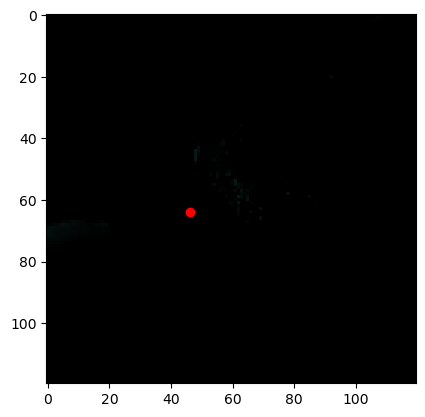

In [4]:
x.getInjectionSite('445', level = 4, plane = 'sagittal', span = 60, showPlot = True)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f69cf7; ">
SdV: What am I looking at in this figure? 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We can quickly look at the slices in each channel using plotSlice or all channels together in plotBlend. 


Grabbing volumes for level: 4
Plotting coronal axis, secion: 3600 (level 4 index: 225)


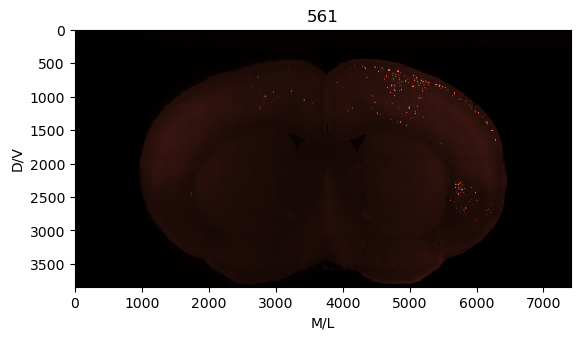

In [5]:
x.plotSlice(ch = "561", plane="coronal", level = 4, section = 3600) 


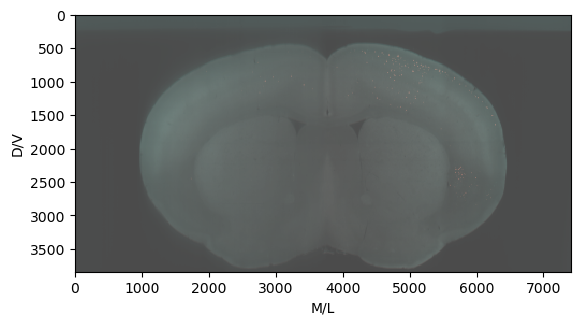

In [6]:
x.plotBlend(plane = "coronal", section = 3600, level = 4, ticks = True)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Neuroglancer link to browse through the data in 3D 
    
(note: we won't use this once we can upload metadata into a df)

In [7]:
x.getNGLink()

https://aind-neuroglancer-sauujisjxq-uw.a.run.app#!s3://aind-open-data/SmartSPIM_681227_2023-07-07_11-21-34_stitched_2023-07-24_20-38-50/neuroglancer_config.json


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The getCellsCCF function will load the spatial coordinates of the detected cells in each channel. Note that these coordinates are transformed into CCF space.<br><br>

In [4]:
cellLocs = x.getCellsCCF(["445", "561"])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Section 2: Quantify cell counts in each thalamic sub-region  
    
We can cross-reference the spatial coordinates of the detected cells in our dataset to the CCF reference brain atlas and identify which brain regions our cells are in. Here, we use brainglobe_atlasapi to import the Allen Mouse Brain Atlas (25um resolution) and identify the spatial bounds of our brain regions of interest. You can use the same approach to target other brain regions by acronym. More details on CCF and the brain region hierarchy here. (to do: point to CCF content) 

In [28]:
# need to test that this works for other brain regions. will there be 
# issues if we want to grab something with subregions below in the hierarchy?

def generate_region_mask(roiList):     
    """
    Generates a boolean ndarray of entire brain space, with brain region ROI's == True to generate spatial mask. 
    
    Parameters: 
    -----------
    roiList : list 
        List of brain region acronyms (e.g. ["MD, PT"])
        
    
    Returns: 
    --------
    roiMask : np.ndarray
        Ndarray the size of the CCF brain template. Spatial coordinates of brain region ROI's == True
        
    """ 
    idList = [atlas.structures[roi]['id'] for roi in roiList] # converts brain region acronym to CCF number id 
    counter = 0 

    for id in idList:
        if counter == 0:
            roiMask = atlas.get_structure_mask(id).astype('bool') 
            counter = counter + 1 

        else: 
            roiMask = np.logical_or.reduce([roiMask, atlas.get_structure_mask(id).astype('bool')]) # iterates through rois, converting each position in the mask to True if it falls within any region mask 
            counter = counter + 1

    roiMask[:, :, 0:220] = False # ignore left hemisphere (half width of ML axis is 228, can revisit exact cutoff)

    return roiMask  

def mask_cells(cellLocs_ch):
    """ 
    Truncates the array of cell locations to those within the brain region ROI's.
    
    Parameters: 
    -----------
    cellLocs_ch : np.ndarray 
        Ndarray of the detected cell locations in a single channel (e.g. cellLocs["561"])
        
    
    Returns: 
    --------
    maskCells : np.ndarray 
        Ndarray of detected cell locations within the brain region ROI's 
    """
    # grab the cell locations for a single channel 
    locCells = cellLocs_ch
    
    # check if cell index is within mask of requested ROIs
    cellInMask = np.zeros(len(locCells),dtype = 'bool')
    for i, pos in enumerate(locCells):
        cellInMask[i] = roiMask[pos[0],pos[1],pos[2]]

    maskCells = locCells[cellInMask] # apply brain region mask 
    
    return maskCells
    
def count_cells_by_region(maskCells, annot):
    """ 
    Counts the cells in each brain region. 
    
    Parameters: 
    -----------
    maskCells : np.ndarray 
        Ndarray of detected cell locations within the brain region ROI's 
        
    atlas : object 
        Allen Mouse Atlas object pulled using BrainGlobeAtlas 
        
        
    Returns: 
    --------
    String of cell counts in each brain region 
    """
    # count the cells in each brain region 
    
    annot = atlas.annotation 
    uniqVals, valCounts = np.unique(annot[maskCells[:,0],maskCells[:,1],maskCells[:,2]], return_counts=True)

    
    for count, name in enumerate(uniqVals):
         print(str(atlas.structures[name]['acronym']) + " " + str(valCounts[count]))



In [29]:
atlasapi.config.write_config_value('brainglobe_dir', '/data/.brainglobe') # points to allen mouse atlases pre-loaded in data folder 
atlas = BrainGlobeAtlas('allen_mouse_25um', check_latest = False)

roiList = ["MD","PT","IAD","PVT","IMD","CM","PCN","CL"]

roiMask = generate_region_mask(roiList)
maskCells = mask_cells(cellLocs["561"])
count_cells_by_region(maskCells, atlas)

PT 15
IMD 477
PVT 150
MD 2018
CL 92
CM 837
PCN 179
IAD 158


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Section 4: How are targeted cells in the thalamus spatially organized?<br> 
    
add more context here

In [37]:
# Restructures data (add more context here)

annot = atlas.annotation 
uniqVals, valCounts = np.unique(annot[maskCells[:,0],maskCells[:,1],maskCells[:,2]], return_counts=True)
cellCCF = annot[maskCells[:,0],maskCells[:,1],maskCells[:,2]]
structDict = {}
for name in uniqVals:
    isStruct = cellCCF == name
    structDict[atlas.structures[name]['acronym']] = isStruct
    

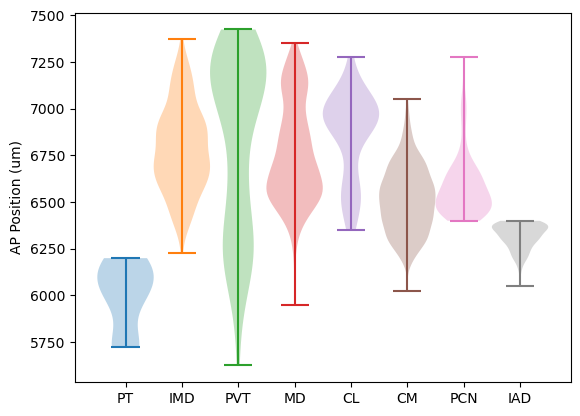

In [38]:
# Violin plots showing the spread of the cells across the anterior-posterior axis in each sub-region 

plt.figure()
a = 1
b = []
c = []
for key, val in structDict.items():
    plt.violinplot(maskCells[val,0]*25, positions=[a], widths = 1)
    b.extend([a])
    c.extend([key])
    a = a + 1
plt.ylabel("AP Position (um)")
plt.xticks(b,c);

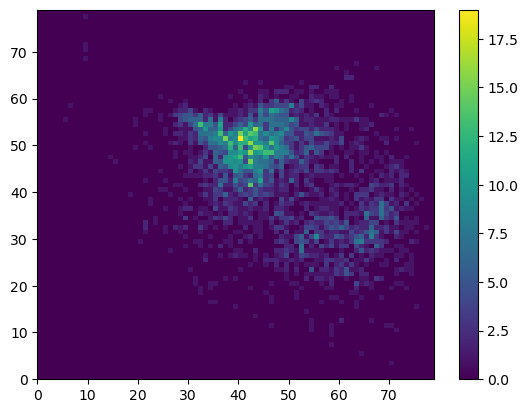

In [39]:
# Heatmap depicting 2D spatial histogram of cell locations 

# to do - label axes, what are the distinctions between xyz coordinates? 
bin_egdes = np.arange(0,80,1)
plt.hist2d(maskCells[:,0]-220, maskCells[:,1]-120, bin_egdes)
plt.colorbar();

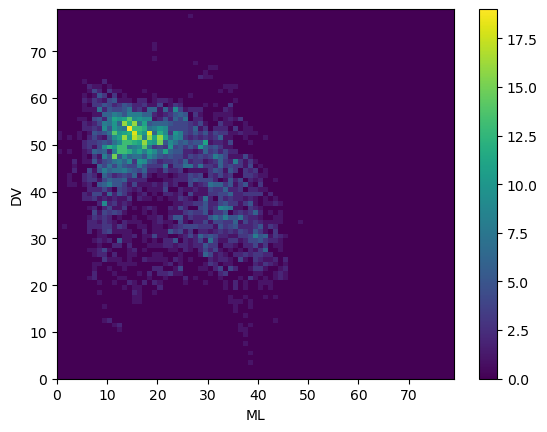

In [40]:
# Heatmap depicting 2D spatial histogram of cell locations 
bin_egdes = np.arange(0,80,1)
plt.hist2d(maskCells[:,2]-220, maskCells[:,1]-120, bin_egdes)
plt.colorbar()
plt.ylabel("DV")
plt.xlabel("ML");

In [ ]:
# to do:import matplotlib ecdf 

# Sort each cell into CCF structures

# uniqVals, valCounts = np.unique(annot[maskCells[:,0],maskCells[:,1],maskCells[:,2]], return_counts=True)
# cellCCF = annot[maskCells[:,0],maskCells[:,1],maskCells[:,2]]
# structDict = {}
# for name in uniqVals:
#     isStruct = cellCCF == name
#     structDict[atlas.structures[name]['acronym']] = isStruct

# plt.ecdf(maskCells[structDict["PVT"],0]*25, label = "PVT")
# plt.ecdf(maskCells[structDict["MD"],0]*25, label = "MD")
# plt.ecdf(maskCells[structDict["PCN"],0]*25, label = "PCN")
# plt.legend()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Section 5: Import metadata and analyze multiple datasets<br>
    
stopping here for now...(rest of notebook is direct copy from MD subdomains)
    
    

In [ ]:
ccfCoordDict = {685903: {'445': [171, 66, 284], '488': [162, 61, 248], '561': [157, 80, 267]},
                698035: {'445': [115, 120, 287], '488': [100, 127, 236], '561': [133, 133, 232]},
                689238: {'445': [126, 92, 259], '488': [127, 84, 271], '561': [122, 138, 237]},
                691387: {'445': [94, 117, 279], '488': [103, 124, 295], '561': [103, 131, 314]},
                691388: {'445': [107, 126, 259], '488': [99, 130, 274], '561': [102, 112, 238]},
                694512: {'445': [142, 101, 237], '488': [154, 75, 254], '561': [157, 89, 238]},
                695721: {'445': [107, 98, 255], '488': [144, 85, 258], '561': [129, 89, 254]},
                696668: {'561': [161, 82, 241]},
                684812: {'445': [166, 65, 197], '488': [166, 70, 265], '561': [167, 85, 240]},
                684821: {'488': [119, 100, 266], '561': [121, 98, 298]},
                689237: {'445': [139, 96, 244], '561': [140, 86, 295]},
                696669: {'445': [141, 87, 289], '561': [105, 113, 287]},
                693977: {'488': [154, 93, 268], '561': [93, 139, 240]},
                698927: {'488': [104, 128, 295], '561': [95, 117, 245]},
                698928: {'488': [146, 138, 232], '561': [145, 88, 271]},
                693979: {'488': [164, 91, 239], '561': [154, 95, 264]},
                693980: {'488': [120, 139, 293], '561': [115, 101, 286]},
                692909: {'561': [122, 132, 294]},
                692907: {'561': [115, 112, 244]},
                692912: {'561': [152, 131, 245]},
                692911: {'561': [123, 127, 294]},
                701750: {'561': [150, 142, 243]},
                701751: {'561': [105, 126, 284]},
                701754: {'561': [146, 80, 255]},
                721832: {'488': [120, 145, 306]}} #manually annotated, estimate injection site later

virusDict = {685903:'AAVrg-XFP',
             # 698034:'AAVrg',
             698035:'AAVrg-XFP',
             689238:'AAVrg-XFP',
             691387:'AAVrg-XFP',
             691388:'AAVrg-XFP',
             694512:'AAVrg-XFP',
             695721:'AAVrg-XFP',
             696668:'AAVrg-XFP',
             684812:'AAVrg-XFP',
             684821:'AAVrg-XFP',
             689237:'AAVrg-XFP',
             696669:'AAVrg-XFP',
             693977:"RabV-XFP",
             698927:"RabV-XFP",
             698928:"RabV-XFP",
             693979:"RabV-XFP",
             693980:"RabV-XFP",
             692909:"AAVrg-Recombinase",
             692907:"AAVrg-Recombinase",
             692912:"AAVrg-Recombinase",
             692911:"AAVrg-Recombinase",
             685110:"AAVrg-Recombinase",
             701750:"RabV-Recombinase",
             701751:"RabV-Recombinase",
             701754:"RabV-Recombinase",
             721832:"AAVrg-XFP"
            }

In [ ]:
# convert this to brainglobe and check that my functions work in batch processing 

In [ ]:
# Create mask of requested subset of CCF structures
roiList = ["MD","PT","IAD","PVT","IMD","CM","PCN","CL"]
roiMap = structure_tree.get_id_acronym_map()
idList = [roiMap[roi] for roi in roiList]
roiMask = rsp.make_structure_mask(idList).astype('bool') # in shape AP, DV, ML
roiMask[:,:,0:220] = False # Ignore left hemisphere (half width of ML axis is 228, can revisit exact cutoff)

In [ ]:
# need to add some context for the "level", what level is best for this analysis and why? 

cellDict = {}
for sample in ccfCoordDict.keys():
    brainObj = brain(sample, level=3)
    chList = list(brainObj.ccfCellsPaths.keys())
    cellLocs = brainObj.getCellsCCF(chList)
    for channel in ccfCoordDict[sample].keys():
        cells = cellLocs[channel]
        cellInMask = np.zeros(len(cells),dtype = 'bool')
        for i, pos in enumerate(cells):
            cellInMask[i] = roiMask[pos[0],pos[1],pos[2]]
        cellDict[str(sample) + " " + channel] = cells[cellInMask]

# brainLists = [691387, 691388, 694512, 698035, 689238]
# chList = ["445","488","561"]
# cellDict = {}
# for sample in brainLists:
#     brainObj = brain(sample)
#     cellLocs = brainObj.getCellsCCF(chList)
#     for channel in chList:
#         cells = cellLocs[channel]
#         cellInMask = np.zeros(len(cells),dtype = 'bool')
#         for i, pos in enumerate(cells):
#             cellInMask[i] = roiMask[pos[0],pos[1],pos[2]]
#         cellDict[str(sample) + " " + channel] = cells[cellInMask]

In [ ]:
# see how many cells are counted w/in the mask for each channel 

for key, val in cellDict.items():
    print(key + ": " + str(len(val)))

In [ ]:
for key, val in cellDict.items():
    if len(val) > 100:
        plt.ecdf(val[:,0]*25, label = key)
plt.legend()

In [ ]:
plt.figure()
a = 1
b = []
c = []
for key, val in cellDict.items():
    if len(val) > 800:
        plt.violinplot(val[:,0]*25, positions=[a], widths = len(val)/6785)
        b.extend([a])
        c.extend([key])
        a = a + 1
plt.ylabel("AP Position (um)")
plt.xticks(b,c);

In [ ]:
#reshape the cellDict w/ the cell locations into a pandas dataframe 

pd.DataFrame.from_dict(cellDict, orient = "index")

In [ ]:
cellDict["689238 561"].shape

In [ ]:
np.vstack(cellDict.values())

In [ ]:
stackCells = np.vstack(cellDict.values())
# stackCells = np.vstack((cellDict["689238 561"],cellDict["689238 488"]))
stepSize = 1
x_bin_edges = np.arange(0,50,stepSize)
y_bin_edges = np.arange(0,70,stepSize)
plt.hist2d(stackCells[:,2]-220, stackCells[:,1]-120, (x_bin_edges, y_bin_edges))
plt.gca().invert_yaxis()
plt.colorbar()
plt.ylabel("DV")
plt.xlabel("ML")
plt.savefig("../results/coronal hist.png",dpi=300)

In [ ]:
i = 41
expList = list(cellDict.keys())
stackCells = cellDict[expList[i]]
x_bin_edges = np.arange(0,50,stepSize)
y_bin_edges = np.arange(0,70,stepSize)
bin_egdes = np.arange(0,80,1)
plt.hist2d(stackCells[:,2]-220, stackCells[:,1]-120, (x_bin_edges, y_bin_edges))
plt.gca().invert_yaxis()
plt.colorbar()
plt.title(expList[i])
plt.ylabel("DV")
plt.xlabel("ML");
plt.savefig("../results/hist ex 3.png",dpi=300, transparent=True)

In [ ]:
stackCells = np.vstack(cellDict.values())
# stackCells = np.vstack((cellDict["689238 561"],cellDict["689238 488"]))
stepSize = 1
x_bin_edges = np.arange(0,50,stepSize)
y_bin_edges = np.arange(0,70,stepSize)
plt.hist2d(stackCells[:,2]-220, stackCells[:,1]-120, (x_bin_edges, y_bin_edges), cmap = 'viridis')
plt.gca().invert_yaxis()
# Set the color of the axes to white
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['top'].set_color('white') 
plt.gca().spines['right'].set_color('white')
plt.gca().spines['left'].set_color('white')

# Set the color of the ticks to white
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# set colorbar label plus label color
cb = plt.colorbar()
cb.set_label('Cell count', color='white')

# set colorbar tick color
cb.ax.yaxis.set_tick_params(color='white')

# set colorbar edgecolor 
cb.outline.set_edgecolor('white')

# set colorbar ticklabels
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='white')
plt.savefig("../results/coronal hist.png",dpi=300, transparent =True)

In [ ]:
stackCells = np.vstack(cellDict.values())
# stackCells = np.vstack((cellDict["689238 561"],cellDict["689238 488"]))
bin_egdes = np.arange(0,80,1)
plt.hist2d(stackCells[:,0]-220, stackCells[:,1]-120, bin_egdes, cmap = "viridis")
plt.gca().invert_yaxis()

# Set the color of the axes to white
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['top'].set_color('white') 
plt.gca().spines['right'].set_color('white')
plt.gca().spines['left'].set_color('white')

# Set the color of the ticks to white
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# set colorbar label plus label color
cb = plt.colorbar()
cb.set_label('Cell count', color='white')

# set colorbar tick color
cb.ax.yaxis.set_tick_params(color='white')

# set colorbar edgecolor 
cb.outline.set_edgecolor('white')

# set colorbar ticklabels
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='white')

plt.savefig("../results/sagittal hist.png",dpi=300, transparent=True)

In [ ]:
plt.figure(dpi=300)
bin_egdes = np.arange(0,80,1)
nExps = len(cellDict)
nRow = int(np.floor(np.sqrt(nExps)))
nCol = int(np.ceil(nExps / nRow))
for i, items in enumerate(cellDict.items(), 1):
    key, val = items
    plt.subplot(nRow,nCol,i)
    plt.hist2d(val[:,2]-220, val[:,1]-120, bin_egdes)
    plt.colorbar()
    plt.title(key)
    plt.ylabel("DV")
    plt.xlabel("ML")
    # plt.rc('font',**{"size": 3})
    plt.tight_layout();

## Try NMF

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
## Prepare data as an array of dictionaries
expList = list(cellDict.keys())
nExps = len(expList)
stepSize = 1
x_bin_edges = np.arange(0,50,stepSize)
y_bin_edges = np.arange(0,70,stepSize)
xLen = len(x_bin_edges)-1
yLen = len(y_bin_edges)-1
vectorSize = xLen*yLen # convert 2d array to vector
histArray = np.empty((nExps,vectorSize))
for i in range(nExps):
    stackCells = cellDict[expList[i]]
    a, xa, ya = np.histogram2d(stackCells[:,2]-220, stackCells[:,1]-120, (x_bin_edges, y_bin_edges)) # Coronal section
    # a, xa, ya = np.histogram2d(stackCells[:,0]-220, stackCells[:,1]-120, (x_bin_edges, y_bin_edges)) # Sagittal section
    histArray[i,:] = a.reshape(1,vectorSize)
# plt.imshow(a.T, origin='lower')

In [ ]:
i = 41
# plt.imshow(histArray[i,:].reshape((xLen,yLen)).T, origin = "lower")
plt.imshow(histArray[i,:].reshape((xLen,yLen)).T)

In [ ]:
model = NMF(n_components=5, init='random', random_state=0)
W = model.fit_transform(histArray)
H = model.components_

In [ ]:
i = 0
# plt.imshow(H[i,:].reshape((xLen,yLen)).T, origin = "lower")
plt.imshow(H[i,:].reshape((xLen,yLen)).T)

In [ ]:
for i in range(5):
    plt.figure()
    # plt.imshow(H[i,:].reshape((xLen,yLen)).T, origin = "lower")
    plt.imshow(H[i,:].reshape((xLen,yLen)).T)
    fn = "../results/component " + str(i) + ".svg"
    plt.savefig(fn,dpi=300)

In [ ]:
vars(model)

In [ ]:
W.shape

In [ ]:
plt.figure()
for i in range(W.shape[1]):
    label = "Component " + str(i)
    plt.plot(W[:,i],label=label)
plt.legend()

In [ ]:
wHeldOut = W
# wHeldOut[12,:] = 0
np.argmax(W[:,0])
list(cellDict.keys())[16]

In [ ]:
np.argmax(W[:,4])
list(cellDict.keys())[48]

In [ ]:
maxComponents = 20
modelErr = np.zeros(maxComponents-1)
norm = np.linalg.norm(histArray)
for i in range(1,maxComponents):
    model = NMF(n_components=i, init='random', random_state=0)
    W = model.fit_transform(histArray)
#     H = model.components_
    modelErr[i-1] = model.reconstruction_err_

In [ ]:
plt.plot(np.arange(1,20),modelErr,'o-')
plt.xticks(np.arange(0,21,5))
plt.ylabel("Reconstruction Error")
plt.xlabel("Num. Components")
plt.savefig("../results/NMF Reconstruction Error.svg",dpi=300)

In [ ]:
plt.figure()
for i in range(W.shape[1]):
    label = "Component " + str(i)
    plt.plot(W[:,i],label=label)
plt.legend()

## Construct dataframe for further analysis of NMF domains

In [ ]:
nComponents = 5
model = NMF(n_components=nComponents, init='random', random_state=0)
W = model.fit_transform(histArray)
H = model.components_

In [ ]:
sampleList = []
chList = []
for count, name in enumerate(expList):
    sampleList.append(np.int64(expList[count][0:6]))
    chList.append(expList[count][7:])
chList = np.array(chList)

In [ ]:
# Format dataframe
ccfData = pd.DataFrame(ccfCoordDict).transpose()
ccfData.insert(0,"Sample",ccfData.index)
ccfData = ccfData.melt(id_vars="Sample", var_name = "Channel", value_name="CCF Coord")
ccfData = ccfData.dropna(axis = 0, how = "any")
# Re-establish index
ccfData.index = ccfData.Sample
ccfData = ccfData.drop(columns = "Sample")

# Add virus dictionary
ccfData.insert(2,"Virus",np.nan)
ccfData.insert(3,"Payload",np.nan)
ccfData.insert(4,"Capsid",np.nan)
for sample, virus in virusDict.items():
    ccfData.loc[sample,["Virus","Payload","Capsid"]] = [virus, virus.split('-')[1], virus.split('-')[0]]

# Get coordinates for projection
ccfCoords = np.array(list(ccfData["CCF Coord"]))

# Get CCF Structure
ccfData.insert(5,"CCF Struct",np.nan)
ccfData.insert(6,"CCF Parent",np.nan)
coordMap = structure_tree.get_structures_by_id(annot[ccfCoords[:,0],ccfCoords[:,1],ccfCoords[:,2]])
for count, structDict in enumerate(coordMap):
    ccfData["CCF Struct"].iloc[count] = structDict["acronym"]
    ccfData["CCF Parent"].iloc[count] = acronymMap[structDict["structure_id_path"][-2]] # get next level parent acronym
    
# Add factor contribution. ccfData order is different from expList due to melt operation.
# Trying to reconcile these here - may be more complicated than need be...
nExps = len(sampleList)
expIndx = np.empty(nExps, dtype = int)
for count, sample in enumerate(zip(ccfData.index, ccfData.Channel)):
    for i in range(nExps):
        if (sample[0] == sampleList[i]) & (sample[1] == chList[i]):
            expIndx[count] = i
            break

for i in range(nComponents):
    field = "Factor " + str(i)
    ccfData[field] = W[expIndx,i] / np.max(W[expIndx,i])

In [ ]:
W[expIndx,0]

In [ ]:
nExps = len(sampleList)
expIndx = np.empty(nExps, dtype = int)
for count, sample in enumerate(zip(ccfData.index, ccfData.Channel)):
    for i in range(nExps):
        if (sample[0] == sampleList[i]) & (sample[1] == chList[i]):
            expIndx[count] = i
            break
            # print(str(sampleList[i]) + ' ' + chList[i] + ' ' + str(i))
    # print(sample[1])

In [ ]:
expIndx

In [ ]:
ccfData.head(5)

In [ ]:
plt.figure()
for i in range(W.shape[1]):
    label = "Component " + str(i)
    plt.plot(W[:,i],label=label)
plt.legend()

In [ ]:
ccfData.head(5)

In [ ]:
i = 2
plt.figure(figsize = (12.8,4.8)) # size of 2 figures
plt.subplot(1,2,1)
plt.imshow(H[i,:].reshape((xLen,yLen)).T, cmap = "viridis")
plt.axis('tight')
plt.subplot(1,2,2)
field = "Factor " + str(i)
sns.stripplot(ccfData,x = "CCF Parent", y = field, color = "gray", order=["ACAd","PL","ILA","FRP","ORBm","ORBl","ORBvl","MOs","AId"], s = 7, jitter = .2)
# sns.despine()
plt.axis('tight');

## Try to add flatmap representations

In [ ]:
from pathlib import Path
from allensdk.core.reference_space_cache import ReferenceSpaceCache
import ccf_streamlines.projection as ccfproj
output_dir = '../scratch/'
# Establish reference space
reference_space_key = 'annotation/ccf_2017'
resolution = 25
rspc = ReferenceSpaceCache(resolution, reference_space_key, manifest=Path(output_dir) / 'manifest.json')
annot, annot_info = rspc.get_annotation_volume()
structure_tree= rspc.get_structure_tree()
rsp = rspc.get_reference_space()
# Set up CCF structure lookup dicts
idMap = structure_tree.get_id_acronym_map()
acronymMap = {IDs:acronym for acronym, IDs in idMap.items()} # invert idMap

In [ ]:
from allensdk.api import api
apiObj = api.Api("../results")
apiObj.retrieve_file_over_http("http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/cortical_coordinates/ccf_2017/ccf_streamlines_assets/view_lookup/flatmap_dorsal.h5","../scratch/flatmap_dorsal.h5")
apiObj.retrieve_file_over_http("http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/cortical_coordinates/ccf_2017/ccf_streamlines_assets/master_updated/labelDescription_ITKSNAPColor.txt","../scratch/labelDescription_ITKSNAPColor.txt")
apiObj.retrieve_file_over_http("http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/cortical_coordinates/ccf_2017/ccf_streamlines_assets/streamlines/closest_surface_voxel_lookup.h5","../scratch/closest_surface_voxel_lookup.h5")
apiObj.retrieve_file_over_http("http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/cortical_coordinates/ccf_2017/ccf_streamlines_assets/master_updated/flatmap_dorsal.nrrd","../scratch/flatmap_dorsal.nrrd")
apiObj.retrieve_file_over_http("http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/cortical_coordinates/ccf_2017/ccf_streamlines_assets/streamlines/surface_paths_10_v3.h5","../scratch/surface_paths_10_v3.h5")

In [ ]:
# Get flatmap boundaries
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file="../scratch/flatmap_dorsal.nrrd",
    labels_file="../scratch/labelDescription_ITKSNAPColor.txt",
)

# And we can get the right hemisphere boundaries that match up with
# our projection if we specify the same configuration
bf_right_boundaries = bf_boundary_finder.region_boundaries(
    # we want the right hemisphere boundaries, but located in the right place
    # to plot both hemispheres at the same time
    hemisphere='right',

    # we also want the hemispheres to be adjacent
    view_space_for_other_hemisphere='flatmap_dorsal',
)

# Setup projector object
ccf_coord_proj = ccfproj.IsocortexCoordinateProjector(
    projection_file="../scratch/flatmap_dorsal.h5",
    surface_paths_file="../scratch/surface_paths_10_v3.h5",
    closest_surface_voxel_reference_file="../scratch/closest_surface_voxel_lookup.h5"
)

In [ ]:
# Project CCF coords onto flatmap
injCoords = ccfCoords*25 # convert from voxels to microns

# Project injection site onto dorsal flatmap
projCoords = ccf_coord_proj.project_coordinates(injCoords, scale='voxels', hemisphere = 'right', view_space_for_other_hemisphere="flatmap_dorsal")

# Add projections to dataframe
ccfData.insert(4,"ML",np.nan)
ccfData.insert(5,"AP",np.nan)
ccfData.insert(6,"DV",np.nan)
ccfData.loc[:,["ML","AP","DV"]] = projCoords

In [ ]:
for k, boundary_coords in bf_right_boundaries.items():
    plt.plot(*boundary_coords.T, color = 'k', lw= 2)

sns.scatterplot(ccfData,x = "ML", y = "AP",edgecolor = "none", hue = "Factor 2",zorder = 2, s =80, palette = "viridis")
plt.legend(loc = "upper right")

In [ ]:
i = 1
plt.figure(figsize = (12.8,4.8)) # size of 2 figures
plt.subplot(1,2,1)
plt.imshow(H[i,:].reshape((xLen,yLen)).T, cmap = "viridis")
plt.axis('tight')
plt.subplot(1,2,2)
field = "Factor " + str(i)
sns.stripplot(ccfData,x = "CCF Parent", y = field, color = "gray", order=["ACAd","PL","ILA","FRP","ORBm","ORBl","ORBvl","MOs","AId"], s = 7, jitter = .2)
# sns.despine()
plt.axis('tight');

In [ ]:
ccfData.sort_values("Factor 1", ascending=False)

In [ ]:
struct = "Factor 1"
plotData = ccfData.copy()
plt.figure(dpi=300)
for k, boundary_coords in bf_right_boundaries.items():
    plt.plot(*boundary_coords.T, color = 'k', lw= 2)

plotData = plotData.sort_values(by=struct,ascending=True) # sort for plotting largest value on top
ax = sns.scatterplot(plotData,x = "ML", y = "AP", s = 45, hue = struct, hue_norm=(0,1),
                     edgecolor = 'black', linewidth = 1, zorder = 2, palette = 'viridis')

norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm = plt.cm.ScalarMappable(cmap="viridis")
plt.colorbar(sm, ax = ax)
ax.get_legend().remove()
plt.title(struct)
plt.savefig("../results/factor 1 flatmap.svg",dpi=300)

In [ ]:
for i in range(5):
    plt.figure()
    # plt.imshow(H[i,:].reshape((xLen,yLen)).T, origin = "lower")
    plt.imshow(H[i,:].reshape((xLen,yLen)).T)
    plt.title(i)

In [ ]:
from matplotlib.colors import Normalize, to_hex

In [ ]:

# rFactor = "Factor 0"
# gFactor = "Factor 1"
# bFactor = "Factor 2"

rFactor = "Factor 1"
gFactor = "Factor 0"
bFactor = "Factor 3"
plotData = ccfData.copy()
plt.figure(dpi=300)
for k, boundary_coords in bf_right_boundaries.items():
    plt.plot(*boundary_coords.T, color = 'k', lw= 2)

plotData['color'] = plotData.apply(lambda row: to_hex((row[rFactor], row[gFactor], row[bFactor])), axis=1)
palette = {color: color for color in plotData['color'].unique()}
plotData = plotData.sort_values(by='color',ascending=True) # sort for plotting largest value on top
ax = sns.scatterplot(plotData,x = "ML", y = "AP", s = 45, hue = "color",
                     edgecolor = 'black', linewidth = 1, zorder = 2, palette = palette)

ax.get_legend().remove()
plt.title(rFactor + " " + gFactor + " " + bFactor)
plt.savefig("../results/joint factors flatmap.svg",dpi=300)

In [ ]:

# rFactor = "Factor 0"
# gFactor = "Factor 1"
# bFactor = "Factor 2"

rFactor = "Factor 1"
gFactor = "Factor 0"
bFactor = "Factor 2"
plotData = ccfData.copy()
plt.figure(dpi=300)
for k, boundary_coords in bf_right_boundaries.items():
    plt.plot(*boundary_coords.T, color = 'k', lw= 2)

plotData['color'] = plotData.apply(lambda row: to_hex((row[rFactor], row[gFactor], row[bFactor])), axis=1)
palette = {color: color for color in plotData['color'].unique()}
plotData = plotData.sort_values(by='color',ascending=True) # sort for plotting largest value on top
ax = sns.scatterplot(plotData,x = "ML", y = "AP", s = 45, hue = "color",
                     edgecolor = 'black', linewidth = 1, zorder = 2, palette = palette)

ax.get_legend().remove()
plt.title(rFactor + " " + gFactor + " " + bFactor)
# plt.savefig("../results/joint factors flatmap.svg",dpi=300)

In [ ]:
# Create RGB colors and convert them to hex
plotData['color'] = plotData.apply(lambda row: to_hex((row['Factor 0'], row['Factor 1'], row['Factor 2'])), axis=1)
# Create a color palette dictionary
palette = {color: color for color in plotData['color'].unique()}
# sns.scatterplot(data=X, x='posX', y='posY', hue='color', palette=X['color'].unique(), legend=False, s=100)

In [ ]:
ccfData.sort_values("Factor 1", ascending=False).head(5)

In [ ]:
lookFor = "698927 488"
for i, name in enumerate(expList):
    if name == lookFor:
        print(name)
        print(i)
        break

In [ ]:
i = 33
plt.imshow(histArray[i,:].reshape((xLen,yLen)).T)

In [ ]:
i = 4
showName = 2
field = "Factor " + str(i)
sns.stripplot(ccfData,x = "CCF Parent", y = field, color = "white", order=["ACAd","PL","ILA","FRP","ORBm","ORBl","ORBvl","MOs","AId"], s = 7, jitter = .2)
sns.despine()
plt.ylabel("Factor " + str(showName), color = "white")
plt.xlabel('Injection Site', color='white')
plt.axis('tight');

# Set the color of the axes to white
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['top'].set_color('white') 
plt.gca().spines['right'].set_color('white')
plt.gca().spines['left'].set_color('white')

# Set the color of the ticks to white
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')


# Set the color of the axis labels to white
# plt.xlabel('X Axis', color='white')
# plt.ylabel('Y Axis', color='white')

plt.savefig("../results/input " + str(showName) + ".svg", dpi = 300, transparent=True)